# change runtime to GPU!!
Rikiya Takehi

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

ModuleNotFoundError: No module named 'torch'

In [2]:
torch.manual_seed(42)

In [3]:
import tensorflow as tf

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [5]:
len(x_train), len(x_test), len(y_train), len(y_test)

(50000, 10000, 50000, 10000)

Image shape: (32, 32, 3)


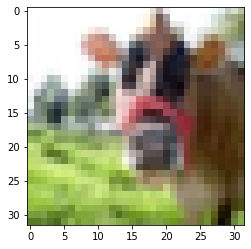

In [6]:
import matplotlib.pyplot as plt
image = x_train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())

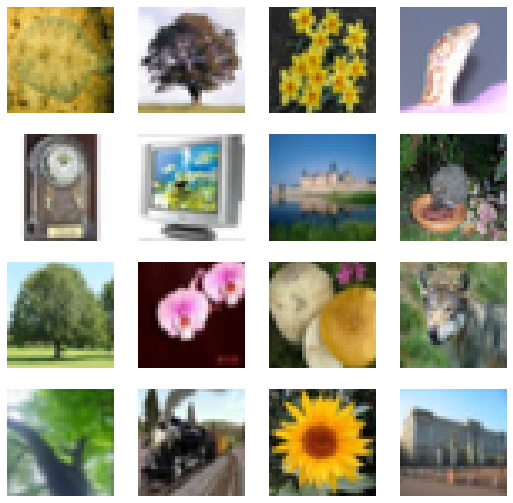

In [7]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(x_train), size=[1]).item()
  img = x_train[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze())
  plt.axis(False)

In [8]:
import numpy as np
x_train = np.moveaxis(x_train, [3, 1, 2], [1, 2, 3]).astype('float32')
x_test = np.moveaxis(x_test, [3, 1, 2], [1, 2, 3]).astype('float32')

x_train /= 255
x_test /= 255

y_train = y_train.reshape(-1).astype('long')
y_test = y_test.reshape(-1).astype('long')

In [9]:
ds_train = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
ds_test  = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

In [21]:
batch_size = 100
num_classes = 100
epochs = 20

In [11]:
dataloader_train = data.DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=False)

In [12]:
class Cifar100Model(nn.Module):
    def __init__(self):
        super(Cifar100Model, self).__init__()
        self.conv11 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv12 = nn.Conv2d(32, 32, 3, padding=1)

        self.conv21 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)

        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.dropout4 = nn.Dropout2d(0.5)


    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout1(x)

        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout2(x)

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.dropout4(x)
        return self.fc3(x)

In [13]:
model = Cifar100Model().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [15]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary (model, input_size=[1, 3, 32, 32])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Layer (type:depth-idx)                   Output Shape              Param #
Cifar100Model                            [1, 100]                  --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─Conv2d: 1-2                            [1, 32, 32, 32]           9,248
├─Dropout2d: 1-3                         [1, 32, 16, 16]           --
├─Conv2d: 1-4                            [1, 64, 16, 16]           18,496
├─Conv2d: 1-5                            [1, 64, 16, 16]           36,928
├─Dropout2d: 1-6                         [1, 64, 8, 8]             --
├─Linear: 1-7                            [1, 1024]                 4,195,328
├─Dropout2d: 1-8                         [1, 1024]                 --
├─Linear: 1-9                            [1, 512]                  524,800
├─Dropout2d: 1-10                        [1, 512]                  --
├─Linear: 1-11                           [1, 100]                  51,300
Total params: 4,836,996
Trainable params: 4,836,996
Non-t

In [16]:
global_step = 0

def train(epoch):
    model.train()
    scheduler.step()

    print("\n--- Epoch : %2d ---" % epoch)
    print("lr : %f" % optimizer.param_groups[0]['lr'])

    steps = len(ds_train)//batch_size
    for step, (images, labels) in enumerate(dataloader_train, 1):
        global global_step
        global_step += 1

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, epochs, step, steps, loss.item()))

In [17]:
def eval(epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for (images, labels) in dataloader_test:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print("Val Acc : %.4f" % (correct/total))

In [22]:
for epoch in range(1, epochs+1):
    train(epoch)
    eval(epoch)


--- Epoch :  1 ---
lr : 0.000900
Epoch [1/20], Step [100/500], Loss: 2.1705
Epoch [1/20], Step [200/500], Loss: 2.8495
Epoch [1/20], Step [300/500], Loss: 2.6002
Epoch [1/20], Step [400/500], Loss: 2.6373
Epoch [1/20], Step [500/500], Loss: 2.3547
Val Acc : 0.3631

--- Epoch :  2 ---
lr : 0.000900
Epoch [2/20], Step [100/500], Loss: 2.4322
Epoch [2/20], Step [200/500], Loss: 2.6827
Epoch [2/20], Step [300/500], Loss: 2.7557
Epoch [2/20], Step [400/500], Loss: 2.5165
Epoch [2/20], Step [500/500], Loss: 2.6091
Val Acc : 0.3723

--- Epoch :  3 ---
lr : 0.000900
Epoch [3/20], Step [100/500], Loss: 2.2220
Epoch [3/20], Step [200/500], Loss: 2.5052
Epoch [3/20], Step [300/500], Loss: 2.4882
Epoch [3/20], Step [400/500], Loss: 2.4712
Epoch [3/20], Step [500/500], Loss: 2.5802
Val Acc : 0.3638

--- Epoch :  4 ---
lr : 0.000900
Epoch [4/20], Step [100/500], Loss: 2.6041
Epoch [4/20], Step [200/500], Loss: 2.2288
Epoch [4/20], Step [300/500], Loss: 2.0912
Epoch [4/20], Step [400/500], Loss: 2.5